In [1]:
import seaborn as sns
import pandas as pd

summ = pd.read_csv('summary_table_v1.4.csv')
raw = pd.read_csv('drugcomb_data_v1.4.csv')

block_to_study = raw[['block_id', 'study_name']].drop_duplicates()
summ = summ.merge(block_to_study, on='block_id')

mono = summ[summ['drug_col'].isna()]
comb = summ[~summ['drug_col'].isna()]

alm_summ = summ[summ['study_name'] == 'ALMANAC']

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
import math
import itertools
import numpy as np

num_bins = 70

def get_bins(df, num_bins, synergy_col):
    zip_synergies = df[synergy_col]
    min_val = math.floor(zip_synergies.min())
    max_val = math.ceil(zip_synergies.max())

    diff = max_val - min_val
    
    base_num_per_bucket, remainder = divmod(diff, num_bins)
    idxs_with_extra = np.random.choice(np.arange(num_bins), remainder, replace=False)
    
    tpls = []
    curr = min_val
    for i in range(num_bins):
        bucket_range = base_num_per_bucket
        if np.isin(i, idxs_with_extra).item():
            bucket_range += 1
            
        tpls.append((curr, curr + bucket_range))
        curr = curr + bucket_range
        
    interv_idx = pd.IntervalIndex.from_tuples(tpls)
    return pd.cut(df[synergy_col], interv_idx, include_lowest=True)
        
def get_triplet_df(df):
    copy = df.copy()
    swap_cols(copy, 'drug_row', 'drug_col')
    
    merged_dfs = [merge(df, copy, merge_on=col_name) for col_name in ['drug_row']]#, 'drug_col']]
    all_df = merged_dfs[0]
    if len(merged_dfs) == 2:
        all_df = all_df.append(merged_dfs[1])
    
    all_df['comb_name'] = all_df[['drug1', 'drug2', 'drug3']].apply(lambda x: '|'.join(sorted(x)), axis=1)
    all_df['comb_name'] = all_df[['comb_name', 'cell_line_name']].apply(lambda x: '|'.join(x), axis=1)
    
    all_df = all_df.drop_duplicates(subset='comb_name')
    return all_df

def merge(df1, df2, merge_on='drug_col'):
    cols = ['drug_row', 'drug_col', 'cell_line_name']

    merged = df1.merge(df2, how='inner', on=[merge_on, 'cell_line_name'])
    
    col_to_fix = 'drug_row' if merge_on == 'drug_col' else 'drug_col'
    cols = {merge_on: 'drug1', '%s_x' % col_to_fix: 'drug2', '%s_y' % col_to_fix: 'drug3'}
    return merged.rename(columns=cols)

def swap_cols(df, first_col_name, second_col_name):
    tmp = df[first_col_name].copy()
    df[first_col_name] = df[second_col_name]
    df[second_col_name] = tmp
    
def _get_selections_inner(df, num_selections):
    '''
    The procedure calls for us to take an even number of samples from
    each bucket.  However, this may not be possible, specifically in the
    case that some bucket does not have the requisite number of items in it.
    
    In this case, we will resample the remaining required samples from the 
    buckets leftover.  This method does one iteration of the bucket sampling,
    and will be called as many times as needed for when buckets do not have
    enough items in them.
    '''
    result_samples = []
    num_leftover = 0
    
    bins = list(sorted(df['bins'].unique(), reverse=True))
    
    base_items_per_bucket, remainder = divmod(num_selections, len(bins))
    idxs_with_extra = np.random.choice(np.arange(len(bins)), remainder, replace=False)
    
    for i, bin_ in enumerate(bins):
        num_samples_this_bin = base_items_per_bucket
        if np.isin(i, idxs_with_extra).item():
            num_samples_this_bin += 1
            
        matches = df[df['bins'] == bin_]
        
        sample = None
        if matches.shape[0] < num_samples_this_bin:
            sample = matches
            num_leftover += num_samples_this_bin - matches.shape[0]
        else:
            sample = matches.sample(n=num_samples_this_bin)
            
        result_samples.append(sample)
        
    return pd.concat(result_samples), num_leftover

def get_selections(df, num_selections):
    # Copy df so we can make deletions
    copy_df = df.copy()
    selections = pd.DataFrame(columns=copy_df.columns)
    
    while num_selections:
        samples, num_leftover = _get_selections_inner(copy_df, num_selections)
        
        # Delete rows from copy_df that we just selected
        copy_df = pd.concat((copy_df, samples)).drop_duplicates(keep=False)
        num_selections = num_leftover
        selections = selections.append(samples)
        
    return selections
        
def add_cid(df):
    ret_df = df.copy()
    
    tpls = []
    for v in ['row', 'col']:
        drug_name = 'drug_%s' % v
        cid_name  = 'drug_%s_cid' % v
        
        intermed_df = raw[[drug_name, cid_name]]
        intermed_df = intermed_df.rename(columns={drug_name: 'drug', cid_name: 'cid'})
        tpls.append(intermed_df)
        
    drug_cid_df = pd.concat(tpls)
    drug_cid_df = drug_cid_df.drop_duplicates()
    
    for idx in ['1', '2', '3']:
        to_drug_name = 'drug%s' % idx
        to_cid_name = 'drug%s_cid' % idx
        
        drug_cid_df = drug_cid_df.rename(columns={'drug': to_drug_name, 'cid': to_cid_name})
        ret_df = ret_df.merge(drug_cid_df, on=to_drug_name)
        drug_cid_df = drug_cid_df.rename(columns={to_drug_name: 'drug', to_cid_name: 'cid'})
        
    return ret_df

k562_raw = raw[raw['cell_line_name'] == 'K-562']
def match(v):
    cols = ['drug1', 'drug2', 'drug3']
    
    res_concs = {drug_col_name: pd.Series() for drug_col_name in cols}
    for perm in itertools.permutations(cols, r=2):
        row_name, col_name = perm[0], perm[1]
        experiments = k562_raw[(k562_raw['drug_row'] == v[row_name]) & (k562_raw['drug_col'] == v[col_name])]
        
        res_concs[row_name] = pd.concat((res_concs[row_name], experiments['conc_r']))
        res_concs[col_name] = pd.concat((res_concs[col_name], experiments['conc_c']))

    
    for drug_name, concs in res_concs.items():
        res_concs[drug_name] = concs.drop_duplicates()
    
    return res_concs['drug1'], res_concs['drug2'], res_concs['drug3']

def match_all_dataset(v):
    cols = ['drug1', 'drug2', 'drug3']
    res_concs = {drug_col_name: pd.Series() for drug_col_name in cols}
    
    for col in cols:
        first_experiments = k562_raw[k562_raw['drug_row'] == v[col]]
        scnd_experiments  = k562_raw[k562_raw['drug_col'] == v[col]]
        
        res_concs[col] = pd.concat((first_experiments['conc_r'], scnd_experiments['conc_c']))
        
    for drug_name, concs in res_concs.items():
        res_concs[drug_name] = concs.drop_duplicates()
    
    return res_concs['drug1'], res_concs['drug2'], res_concs['drug3']

def is_10x_multiple(x, y):
    return np.isclose(x, y * 10)

def is_val_base(x, y):
    if np.isclose(x, y):
        return True
    
    v = x / y
    while v > 1:
        v /= 10
    
    return v.is_integer()

def constr_new_dosing(v):
    result = []
    for item in v:
        item = item[item != 0.0]
        
        bases = [z for z in item if not any(is_10x_multiple(z, x) and z != x for x in item)]
        multiple_sets = [pd.Series([z for z in item if is_val_base(z, base)]) for base in bases]
        medians = pd.Series(srs.median() for srs in multiple_sets)
        
        # Take the median of the different multiple sets
        median = medians.median()
        
        result.append(pd.Series([0., median / 10, median, median * 10]))
    
    return result[0], result[1], result[2]
        
def get_doses_naive(series, idx):
    return pd.Series([item[idx].tolist() for item in series])

def plot_for_matches(srs):
    for idx in range(3):
        plt.figure()
        sns.histplot(get_doses_naive(srs, idx).apply(lambda x: x.shape[0]))
        plt.title('Histogram for Drug %d' % (idx + 1))
        plt.xlabel('Number of Unique Dose Concentrations for Drug')
    
def get_cell_line_triplets(cell_line_name):
    triplet_df = get_triplet_df(alm_summ)
    line_triplets = triplet_df[triplet_df['cell_line_name'] == cell_line_name]
    line_triplets['expected_zip'] = (line_triplets['synergy_zip_x'] + line_triplets['synergy_zip_y']) / 2

    line_triplets['bins'] = get_bins(line_triplets, 30, 'expected_zip')
    return line_triplets
    
def get_apexbio_triplets(triplets_df):
    sheet = pd.read_excel('~/Downloads/k562_drugs_and_in_apexbiolib_status_ams.xlsx')
    possible_in_apexbio = sheet[(~sheet['UsedInChemoGenomics-at-IRIC'].isna()) | sheet['Is in ApexBio']]
    apexbio_names = possible_in_apexbio['Name'].drop_duplicates()

    apexbio_triplets_cond = triplets_df['drug1'].isin(apexbio_names) & triplets_df['drug2'].isin(apexbio_names) & triplets_df['drug3'].isin(apexbio_names)
    return triplets_df[apexbio_triplets_cond]

def get_line_selections(cell_line_name, num_selections, line_triplets=None):
    if line_triplets is None:
        line_triplets = get_cell_line_triplets(cell_line_name)
        
    apexbio_triplets = get_apexbio_triplets(line_triplets)
    
    apexbio_selections = get_selections(apexbio_triplets, num_selections)
    apexbio_selections_cid = add_cid(apexbio_selections)
    apexbio_selections_cid_uniq = apexbio_selections_cid.drop_duplicates(subset='comb_name')

    matches = apexbio_selections_cid_uniq[['drug1', 'drug2', 'drug3']].apply(lambda x: match(x), axis=1)
    new_dosings = matches.apply(lambda x: constr_new_dosing(x))

    for i in range(3):
        apexbio_selections_cid_uniq['drug%d_dosings' % (i + 1)] = get_doses_naive(new_dosings, i).tolist()
        apexbio_selections_cid_uniq['drug%d_dosings_unit' % (i + 1)] = 'uM'
        
    return apexbio_selections_cid_uniq

In [3]:
triplet_df = get_triplet_df(alm_summ)
k562_triplets = triplet_df[triplet_df['cell_line_name'] == 'K-562']
k562_triplets['expected_zip'] = (k562_triplets['synergy_zip_x'] + k562_triplets['synergy_zip_y']) / 2

k562_triplets['bins'] = get_bins(k562_triplets, 30, 'expected_zip')

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


bins
(-17, -15]       12
(-15, -13]      102
(-13, -11]      528
(-11, -9]      2000
(-9, -7]       5376
(-7, -5]      11264
(-5, -3]      19962
(-3, -2]      13706
(-2, 0]       32302
(0, 2]        29190
(2, 4]        19455
(4, 6]        11427
(6, 7]         3780
(7, 9]         5031
(9, 10]        1745
(10, 11]       1495
(11, 13]       2091
(13, 15]       1289
(15, 17]        754
(17, 19]        381
(19, 21]        223
(21, 23]        123
(23, 25]         69
(25, 27]         46
(27, 29]         17
(29, 31]         16
(31, 33]          4
(33, 35]          5
(35, 37]          2
(37, 39]          1
dtype: int64

In [4]:
sheet = pd.read_excel('~/Downloads/k562_drugs_and_in_apexbiolib_status_ams.xlsx')
possible_in_apexbio = sheet[(~sheet['UsedInChemoGenomics-at-IRIC'].isna()) | sheet['Is in ApexBio']]
apexbio_names = possible_in_apexbio['Name'].drop_duplicates()

apexbio_k562_cond = k562_triplets['drug1'].isin(apexbio_names) & k562_triplets['drug2'].isin(apexbio_names) & k562_triplets['drug3'].isin(apexbio_names)
apexbio_k562_triplets = k562_triplets[apexbio_k562_cond]

In [9]:
apexbio_selections = get_selections(apexbio_k562_triplets, 500)
apexbio_selections_cid = add_cid(apexbio_selections)
apexbio_selections_cid_uniq = apexbio_selections_cid.drop_duplicates(subset='comb_name')

matches = apexbio_selections_cid_uniq[['drug1', 'drug2', 'drug3']].apply(lambda x: match(x), axis=1)
new_dosings = matches.apply(lambda x: constr_new_dosing(x))

for i in range(3):
    apexbio_selections_cid_uniq['drug%d_dosings' % (i + 1)] = get_doses_naive(new_dosings, i).tolist()
    apexbio_selections_cid_uniq['drug%d_dosings_unit' % (i + 1)] = 'uM'

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [11]:
apexbio_selections_cid_uniq[['drug1', 'drug2', 'drug3']]

,drug1,drug2,drug3
0,ACTINOMYCIN D,LAPATINIB,VEMURAFENIB
1,DASATINIB,LAPATINIB,VEMURAFENIB
2,ACTINOMYCIN D,TRETINOIN,VEMURAFENIB
3,DAUNORUBICIN HYDROCHLORIDE,TRETINOIN,VEMURAFENIB
4,ACTINOMYCIN D,TAMOXIFEN CITRATE,VEMURAFENIB
...,...,...,...
523,CO-V,NSC-127716,IFOSFAMIDE
524,QUINACRINE HYDROCHLORIDE,TOPOTECAN HYDROCHLORIDE,MECHLORETHAMINE HYDROCHLORIDE
525,CISPLATINO,ARSENIC TRIOXIDE,THALIDOMIDE
526,PRALATREXATE,ARSENIC TRIOXIDE,5-FLUORO-2'-DEOXYURIDINE


In [16]:
apexbio_selections_cid_uniq[['drug1', 'drug2']].apply(lambda x: '|'.join(sorted(x[['drug1', 'drug2']])), axis=1)

0                               ACTINOMYCIN D|LAPATINIB
1                                   DASATINIB|LAPATINIB
2                               ACTINOMYCIN D|TRETINOIN
3                  DAUNORUBICIN HYDROCHLORIDE|TRETINOIN
4                       ACTINOMYCIN D|TAMOXIFEN CITRATE
                             ...                       
523                                     CO-V|NSC-127716
524    QUINACRINE HYDROCHLORIDE|TOPOTECAN HYDROCHLORIDE
525                         ARSENIC TRIOXIDE|CISPLATINO
526                       ARSENIC TRIOXIDE|PRALATREXATE
527                   ARSENIC TRIOXIDE|CYCLOPHOSPHAMIDE
Length: 500, dtype: object

In [17]:
type(apexbio_selections_cid_uniq[['drug1', 'drug2']])

pandas.core.frame.DataFrame

In [79]:
def _get_comb_counts(df):
    all_combs = pd.concat((df['comb1'], df['comb2'], df['comb3']))
    combs_frame = all_combs.to_frame().rename(columns={0: 'comb'})
    sizes = combs_frame.groupby('comb').size()
    
    return sizes.to_dict()

def get_comb_counts_df(init_df):
    df = init_df.copy()
    
    for i, idx_pair in enumerate([[1, 2], [1, 3], [2, 3]]):
        cols = ['drug%d' % v for v in idx_pair]
        df['comb%d' % (i + 1)] = df[cols].apply(lambda x: '|'.join(sorted(x[cols])), axis=1)
    
    comb_counts = _get_comb_counts(df)
    
    for i in range(3):
        df['comb_count%d' % (i + 1)] = df['comb%d' % (i + 1)].apply(lambda x: comb_counts[x])
    
    return df
    
def get_leq_than_x_combs_triplets(init_df, num_combs_leq):
    df = get_comb_counts_df(init_df)
    idx = (df['comb_count1'] <= num_combs_leq) & (df['comb_count2'] <= num_combs_leq) & (df['comb_count3'] <= num_combs_leq)
    
    return init_df[idx]

In [62]:
samp = get_leq_than_x_combs_triplets(apexbio_selections_cid_uniq, 3)

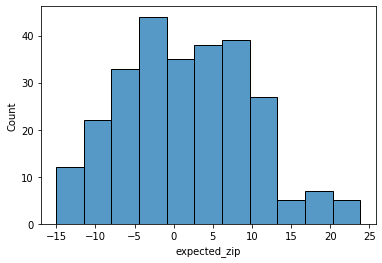

In [63]:
sns.histplot(samp['expected_zip'])

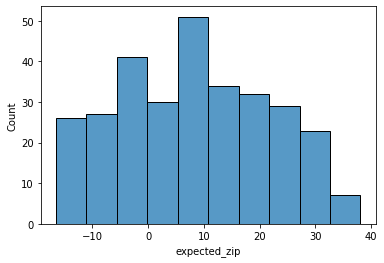

In [93]:
sns.histplot(df['expected_zip'])

In [75]:
df = get_line_selections('K-562', 300, k562_triplets)

/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:140: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jarridr/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:248: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

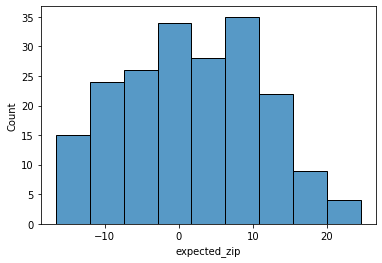

In [77]:
sns.histplot(get_leq_than_x_combs_triplets(df, 3)['expected_zip'])

In [80]:
df = get_comb_counts_df(df)

In [84]:
vals = None
for i in range(3):
    srs = (df['comb_count%d' % (i + 1)] > 3).astype(int)
    if vals is None:
        vals = srs
    else:
        vals = vals + srs
        

In [88]:
df['counts_over_3'] = vals

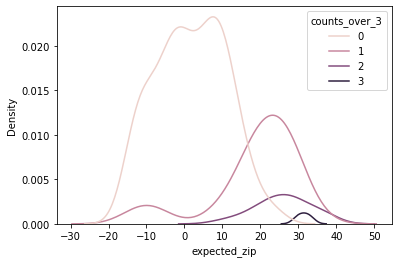

In [92]:
sns.kdeplot(data=df, x='expected_zip', hue='counts_over_3')

In [110]:
import heapq

class Bin:
    def __init__(self, bin_, num_total, num_missing):
        self.bin_ = bin_
        self.num_total = num_total
        self.num_missing = num_missing
    
    @property
    def proportion_missing(self):
        return self.num_missing / self.num_total
    
    # use negative of each here as we want to do a max priority-queue
    def __lt__(self, other):
        return -self.proportion_missing < -other.proportion_missing

def _get_missing_bins(init_df, selections):
    num_in_bins_pre = init_df.groupby('bins').size().to_dict()
    num_in_bins_seld = selections.groupby('bins').size().to_dict()

    bins = []
    for bin_id in num_in_bins_pre.keys():
        num_total = num_in_bins_pre[bin_id]
        num_missing = num_total
        if bin_id in num_in_bins_seld:
            num_missing -= num_in_bins_seld[bin_id]
            
        if num_missing != 0:
            bins.append(Bin(bin_id, num_total, num_missing))
            
    return bins

def _get_sels_non_sels(df, num_at_most):
    if 'comb_count1' not in df:
        df = get_comb_counts_df(df)
        
    all_combs_naive_valid = (fdf['comb_count1'] <= num_combs_leq) & \
                            (df['comb_count2'] <= num_combs_leq) & \
                            (df['comb_count3'] <= num_combs_leq)
    
    selections = df[all_combs_naive_valid]
    non_selections = df[~all_combs_naive_valid]
    
    return selections, non_selections
    
def _get_comb_avail_count(df, num_at_most):
    non_seld_combs = pd.concat((non_selections['comb%d' % (i + 1)] for i in range(3))).drop_duplicates()
    return {comb: num_at_most for comb in non_seld_combs}
    
def select_values_greedy(df, num_at_most):
    selections, non_selections = _get_sels_non_sels(df, num_at_most)
    
    missing_bins = _get_missing_bins(df, selections)
    non_seld_bins = non_selections.groupby('bins').groups
    
    non_seld_combs = pd.concat((non_selections['comb%d' % (i + 1)] for i in range(3))).drop_duplicates()
    comb_avail_count = _get_comb_avail_count()

In [106]:
df.iloc[list(df.groupby('bins').groups.values())[0]]

,block_id_x,drug1,drug2,cell_line_name,conc_r_unit_x,conc_c_unit_x,css_x,synergy_zip_x,synergy_bliss_x,synergy_loewe_x,...,drug2_dosings_unit,drug3_dosings,drug3_dosings_unit,comb1,comb2,comb3,comb_count1,comb_count2,comb_count3,counts_over_3
187,434991,AZACYTIDINE,NSC256439,K-562,uM,uM,49.4160,-11.804748,-12.289161,-7.425185,...,uM,"[0.0, 0.05500000000000001, 0.55, 5.5]",uM,AZACYTIDINE|NSC256439,AZACYTIDINE|CYTARABINE HYDROCHLORIDE,CYTARABINE HYDROCHLORIDE|NSC256439,2,1,1,0
276,310075,CHLORAMBUCIL,CYTARABINE HYDROCHLORIDE,K-562,uM,uM,42.0025,-4.704251,-4.173443,-6.593808,...,uM,"[0.0, 0.3, 3.0, 30.0]",uM,CHLORAMBUCIL|CYTARABINE HYDROCHLORIDE,CHLORAMBUCIL|LENALIDOMIDE,CYTARABINE HYDROCHLORIDE|LENALIDOMIDE,1,1,1,0
278,295363,CISPLATINO,ARSENIC TRIOXIDE,K-562,uM,uM,77.5835,31.971853,25.294883,23.910785,...,uM,"[0.0, 0.3, 3.0, 30.0]",uM,ARSENIC TRIOXIDE|CISPLATINO,CISPLATINO|LENALIDOMIDE,ARSENIC TRIOXIDE|LENALIDOMIDE,4,1,1,1
